# Simple Meta-Learning Time Series Forecasting

Following the exact mathematical specification:
1. Generate synthetic univariate series
2. Create patches with history length L and forecast horizon H
3. Normalize using global series statistics
4. Split into context and query patches for meta-learning

In [14]:
import sys
import os

# Go up one level to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)

In [15]:
# Imports
import torch
import matplotlib.pyplot as plt
import numpy as np

# Import custom dataset
from util.config_util import ShapeConfig, dotdict
from data.variable_meta_dataset import VariableMetaDataset
from models.LinearPFN import LinearPFN

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Configuration for synthetic data generation
shape_config = ShapeConfig(
    n_context=2,
    n_sequence=2_000,  # Length of synthetic series
    n_features=1,    # Univariate series
    n_heldout=1,
    n_prompt=1
)

# Hyperprior parameters for realistic time series
seasonality_base = 1.5
w, m, a = seasonality_base*1, seasonality_base*2, seasonality_base*4

hyperprior_params = dotdict({
    # Seasonality parameters
    'a_min': -a, 'a_max': a, 'a_fixed_variance': 0.15,
    'm_min': -m, 'm_max': m, 'm_fixed_variance': 0.15,
    'w_min': -w, 'w_max': w, 'w_fixed_variance': 0.15,
    
    # Trend parameters
    'trend_lin_min': -0.006, 'trend_lin_max': 0.006, 'trend_lin_fixed_variance': 0.005,
    'trend_exp_min': 1 - 0.002, 'trend_exp_max': 1 + 0.002, 'trend_exp_fixed_variance': 0.001,
    'trend_exp_multiplier': 200,
    
    # Noise and resolution
    'noise_k_min': 0.7, 'noise_k_max': 2.2,
    'resolution_min': 0.2, 'resolution_max': 0.8, 'resolution_multiplier': 30,
    
    # Other parameters
    'harmonics_min': 2, 'harmonics_max': 4,
    'discreteness_min': 1, 'discreteness_max': 3,
    'bias_zi_min': 0.8, 'bias_zi_max': 3.0,
    'amplitude_min': 0.8, 'amplitude_max': 3.0,
    'non_negative_prob': 0.3,
    'offset_lin_min': -0.3, 'offset_lin_max': 0.6,
    'offset_exp_min': -0.5, 'offset_exp_max': 1.0,
    'f_zi_min': 0.0, 'f_zi_max': 0.35, 'f_zi_fixed_variance': 0.2
})

In [17]:
dataset = VariableMetaDataset(
    shape_config=shape_config,
    hyperprior_params=hyperprior_params,
    L=96, H=96,
    C_range=(32, 256),
    Q_range=(1, 16),
    device=device,
    sample_log_uniform=False
)

# Test variable sampling
print("\nTesting variable C,Q sampling:")
for i in range(5):
    task = dataset.create_meta_task()
    C_actual = task['ctx_x'].shape[0]
    Q_actual = task['qry_x'].shape[0]
    print(f"  Sample {i+1}: C={C_actual}, Q={Q_actual}")
    print(f"    Series stats: μ={task['stats']['mu']:.3f}, σ={task['stats']['sigma']:.3f}")

Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x700be86b8d30> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: (32, 256) (uniform)
  Q range: (1, 16)
  Max patches needed: C=256, Q=16

Testing variable C,Q sampling:
  Sample 1: C=222, Q=3
    Series stats: μ=0.326, σ=0.272
  Sample 2: C=249, Q=5
    Series stats: μ=22.477, σ=11.735
  Sample 3: C=167, Q=3
    Series stats: μ=153.016, σ=139.804
  Sample 4: C=153, Q=13
    Series stats: μ=1573.590, σ=1276.026
  Sample 5: C=163, Q=7
    Series stats: μ=51.345, σ=39.623


In [26]:
# ===== TRAINING: 500K TASKS =====

model = LinearPFN(
    L=dataset.L,
    H=dataset.H,
    d=768,      # embedding size
    L_blk=16,   # number of transformer blocks
    n_heads=12, # number of attention heads
    d_ff=3072,  # feedforward size
    dropout=0.1
).to(device)

model_path = f'../ckpts/LinearPFN/v0/L96_H96_d768_Lblk16_n12_dff3072_do0.1_C32-1536_Q1-32'

ckpt = torch.load(os.path.join(model_path, 'best_model.pt'), weights_only=False)
model.load_state_dict(ckpt['model_state_dict'])

model_params = sum(p.numel() for p in model.parameters())

print(f"Model: {model_params:,} parameters")

Model: 113,776,236 parameters


Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x700c2cdcf490> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: 50 (log-uniform)
  Q range: 1
  Max patches needed: C=50, Q=1
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x700bfb8c5240> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: 128 (log-uniform)
  Q range: 4
  Max patches needed: C=128, Q=4
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x700bfac6f1f0> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: 176 (log-uniform)
  Q range: 2
  Max patches needed: C=176, Q=2
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x700be8486620> {}
Variable SimpleMetaTaskDataset:
  L=96, H=96
  C range: 250 (log-uniform)
  Q range: 1
  Max patches needed: C=250, Q=1


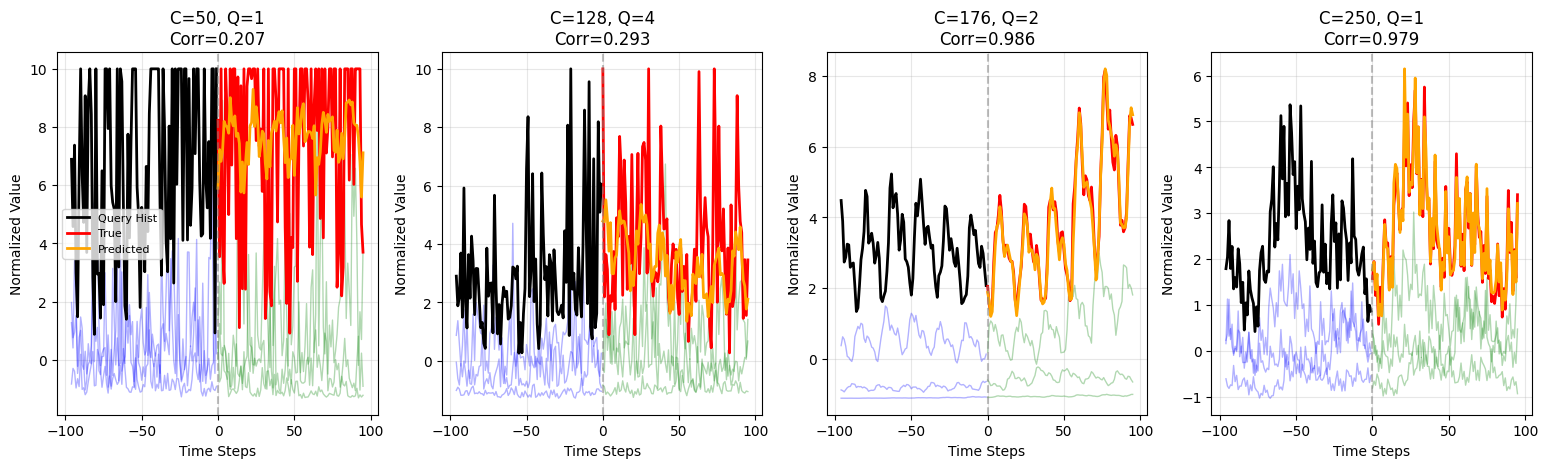

In [28]:
# ===== 500K TRAINING VISUALIZATION & ANALYSIS =====
plt.figure(figsize=(24, 16))

model.eval()

# Generate test examples with different C,Q combinations
test_combinations = [
    (50, 1),    # Small context, single query
    (128, 4),   # Medium context, multiple queries
    (176, 2),   # Large context, few queries
    (250, 1),   # Very large context, single query (extrapolation)
]

test_results = []
for i, (C_test, Q_test) in enumerate(test_combinations):
    # Create custom dataset for this C,Q
    dataset_test = VariableMetaDataset(
        shape_config=shape_config,
        hyperprior_params=hyperprior_params,
        L=dataset.L, H=dataset.H,
        C_range=C_test, Q_range=Q_test,  # Fixed sizes
        device=device)
    
    task = dataset_test.create_meta_task()
    
    ctx_x = task['ctx_x'].unsqueeze(0).float().to(device)
    ctx_z = task['ctx_z'].unsqueeze(0).float().to(device)
    qry_x = task['qry_x'].unsqueeze(0).float().to(device)
    qry_z = task['qry_z'].unsqueeze(0).float().to(device)
    t_ctx = torch.tensor(task['endpoints']['ctx'], dtype=torch.long).unsqueeze(0).to(device)
    t_qry = torch.tensor(task['endpoints']['qry'], dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        mu = model(ctx_x, ctx_z, qry_x, t_ctx, t_qry)
    
    # Calculate correlation
    mu_flat = mu.flatten().cpu()
    qry_z_flat = qry_z.flatten().cpu()
    corr = torch.corrcoef(torch.stack([mu_flat, qry_z_flat]))[0, 1]
    
    # Visualize this test case
    plt.subplot(3, 5, 6 + i)
    
    hist_points = np.arange(-dataset.L, 0)
    fore_points = np.arange(0, dataset.H)
    
    # Show a few context examples
    ctx_x_cpu = task['ctx_x'].cpu()
    ctx_z_cpu = task['ctx_z'].cpu()
    n_show = min(3, C_test)
    for j in range(n_show):
        alpha = 0.3 if n_show > 1 else 0.6
        plt.plot(hist_points, ctx_x_cpu[j], 'b-', alpha=alpha, linewidth=1)
        plt.plot(fore_points, ctx_z_cpu[j], 'g-', alpha=alpha, linewidth=1)
    
    # Show query (first one if multiple)
    qry_idx = 0
    qry_x_cpu = task['qry_x'][qry_idx].cpu()
    qry_z_true = task['qry_z'][qry_idx].cpu()
    qry_pred = mu[0, qry_idx].cpu()
    # qry_std = sigma[0, qry_idx].cpu()
    
    plt.plot(hist_points, qry_x_cpu, 'k-', linewidth=2, label='Query Hist')
    plt.plot(fore_points, qry_z_true, 'r-', linewidth=2, label='True')
    plt.plot(fore_points, qry_pred, 'orange', linewidth=2, label='Predicted')
    # plt.fill_between(fore_points, qry_pred - 2*qry_std, qry_pred + 2*qry_std, 
                    #  alpha=0.2, color='orange', label='±2σ')
    
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Value')
    plt.title(f'C={C_test}, Q={Q_test}\nCorr={corr:.3f}')
    if i == 0:
        plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

plt.show()